
option price comparision
  model   |  parameters  | European | American 
---------|--------|-------------|-------------
Black-Scholes | q=0    | 28.600335 | N/A 
Black-Scholes | q=0.02 | 22.747072 | N/A 
binomial tree | q=0    | 28.599524 | 28.599524
binomial tree | q=0.02 | 22.746607 | 22.831403
trinomial tree | q=0    | 28.599589 | 28.599589
trinomial tree | q=0.02 | 22.746957 | 22.831793


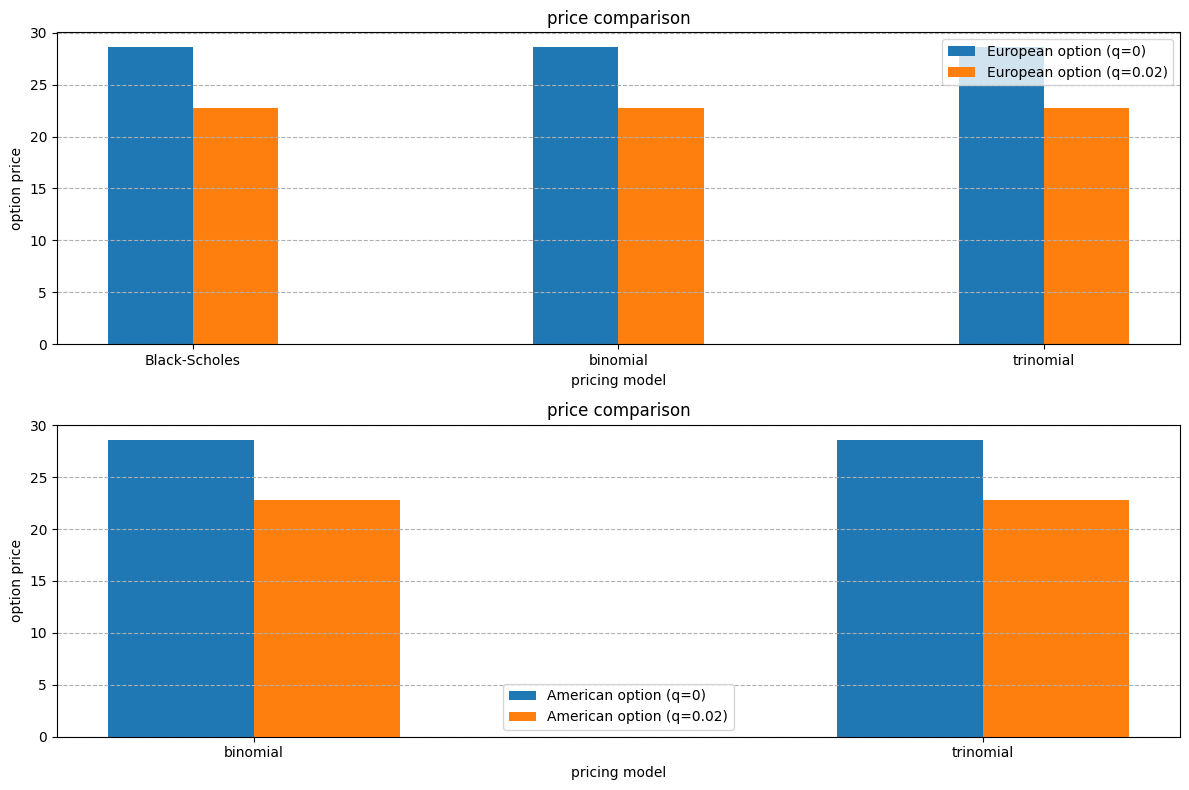


convergence and computational complexity analysis

convergence of binomial tree


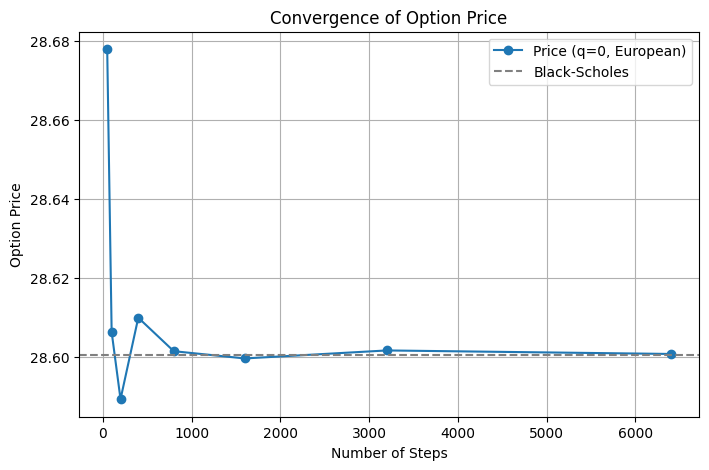

q=0, European: Average local estimated convergence order: 1.0548
q=0, European: Global estimated convergence order: 3.3346

convergence of trinomial tree


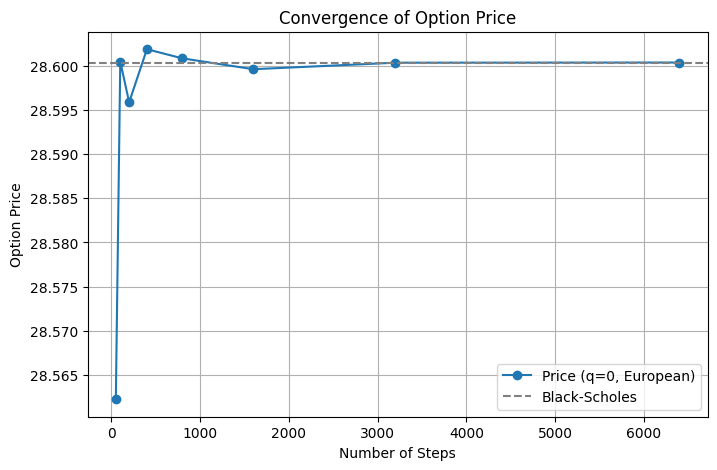

q=0, European: Average local estimated convergence order: 1.7990
q=0, European: Global estimated convergence order: 3.1815


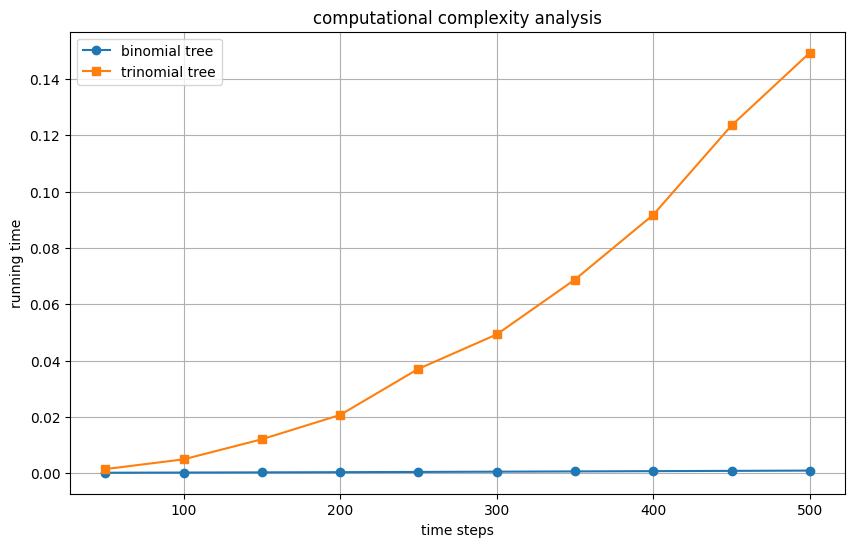

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm

def black_scholes_price(S, K, r, sigma, T, q=0, is_call=True):
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if is_call:
        price = S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r*T) * norm.cdf(-d2) - S * np.exp(-q*T) * norm.cdf(-d1)
    return price


def binomial_price(S, K, r, sigma, T, steps, q=0, is_call=True, is_american=False):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    asset_prices = np.array([S * (u ** j) * (d ** (steps - j)) for j in range(steps + 1)])
    if is_call:
        option_values = np.maximum(asset_prices - K, 0)
    else:
        option_values = np.maximum(K - asset_prices, 0)

    for i in range(steps - 1, -1, -1):
        option_values = discount * (p * option_values[1:i+2] + (1 - p) * option_values[0:i+1])
        if is_american:
            asset_prices = np.array([S * (u ** j) * (d ** (i - j)) for j in range(i + 1)])
            if is_call:
                exercise = np.maximum(asset_prices - K, 0)
            else:
                exercise = np.maximum(K - asset_prices, 0)
            option_values = np.maximum(option_values, exercise)
    return option_values[0]

def trinomial_tree_fixed(S0, K, T, r, sigma, n, q=0, lambda_=1.22, is_call=True, is_american=False):

    dt = T / n
    u = np.exp(lambda_ * sigma * np.sqrt(dt))
    d = 1 / u

    pu = 1/(2 * lambda_**2) + ((r - q) - 0.5 * sigma**2) * np.sqrt(dt) / (2 * lambda_ * sigma)
    pd = 1/(2 * lambda_**2) - ((r - q) - 0.5 * sigma**2) * np.sqrt(dt) / (2 * lambda_ * sigma)
    pm = 1 - pu - pd

    if pu < 0 or pd < 0 or pm < 0:
        raise ValueError("Negative probabilities detected. Increase lambda_.")

    discount = np.exp(-r * dt)

    asset_prices = {}
    for j in range(-n, n+1):
        asset_prices[(n, j)] = S0 * (u ** j)

    option_values = {}
    for j in range(-n, n+1):
        price = asset_prices[(n, j)]
        if is_call:
            option_values[(n, j)] = max(price - K, 0)
        else:
            option_values[(n, j)] = max(K - price, 0)

    for i in range(n-1, -1, -1):
        for j in range(-i, i+1):
            asset_prices[(i, j)] = S0 * (u ** j)

            hold_value = discount * (
                pu * option_values.get((i+1, j+1), 0) +
                pm * option_values.get((i+1, j), 0) +
                pd * option_values.get((i+1, j-1), 0)
            )

            if is_american:
                price = asset_prices[(i, j)]
                if is_call:
                    exercise_value = max(price - K, 0)
                else:
                    exercise_value = max(K - price, 0)
                option_values[(i, j)] = max(hold_value, exercise_value)
            else:
                option_values[(i, j)] = hold_value

    return option_values[(0, 0)]


def estimate_convergence_order_improved(pricing_func, S0, K, r, sigma, T, q, is_call, is_american,
                                        use_trinomial=False, lambda_=1.22, threshold=1e-8):

    steps_list = [50, 100, 200, 400, 800, 1600, 3200, 6400]
    prices = []
    for steps in steps_list:
        if use_trinomial:
            price = pricing_func(S0, K, T, r, sigma, steps, q=q, lambda_=lambda_, is_call=is_call, is_american=is_american)
        else:
            price = pricing_func(S0, K, r, sigma, T, steps, q=q, is_call=is_call, is_american=is_american)
        prices.append(price)
    plt.figure(figsize=(8,5))
    plt.plot(steps_list, prices, 'o-', label=f'Price (q={q}, {"American" if is_american else "European"})')
    if not is_american:
        bs_price = black_scholes_price(S0, K, r, sigma, T, q=q, is_call=is_call)
        plt.axhline(y=bs_price, color='gray', linestyle='--', label='Black-Scholes')
    plt.xlabel('Number of Steps')
    plt.ylabel('Option Price')
    plt.title('Convergence of Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    local_estimates = []
    epsilon = 1e-12
    for i in range(len(steps_list) - 2):
        V_N = prices[i]
        V_2N = prices[i+1]
        V_4N = prices[i+2]
        diff1 = abs(V_2N - V_N)
        diff2 = abs(V_4N - V_2N)
        if diff1 < threshold or diff2 < threshold:
            continue
        p_local = np.log((diff1 + epsilon) / (diff2 + epsilon)) / np.log(2)
        local_estimates.append(p_local)
    average_local = np.mean(local_estimates) if local_estimates else None

    V_star = prices[-1]
    errors = [abs(price - V_star) for price in prices]
    log_steps = np.log(steps_list)
    log_errors = np.log(np.array(errors) + epsilon)
    global_coeffs = np.polyfit(log_steps, log_errors, 1)
    global_order = -global_coeffs[0]

    print(f"q={q}, {'American' if is_american else 'European'}: Average local estimated convergence order: {average_local:.4f}" if average_local is not None else "No local estimates")
    print(f"q={q}, {'American' if is_american else 'European'}: Global estimated convergence order: {global_order:.4f}")

    return local_estimates, average_local, global_order, steps_list, prices

def analyze_computational_complexity(pricing_func, S0, K, r, sigma, T, q, is_call, is_american, use_trinomial=False, lambda_=1.22):
    steps_range = np.arange(50, 550, 50)
    runtimes = []
    for steps in steps_range:
        start_time = time.time()
        if use_trinomial:
            pricing_func(S0, K, T, r, sigma, steps, q=q, lambda_=lambda_, is_call=is_call, is_american=is_american)
        else:
            pricing_func(S0, K, r, sigma, T, steps, q=q, is_call=is_call, is_american=is_american)
        runtimes.append(time.time() - start_time)
    return steps_range, runtimes

if __name__ == '__main__':
    S0 = 90
    K = 100
    r = 0.05
    sigma = 0.3
    T = 5
    q_no_div = 0
    q_div = 0.02
    is_call = True
    steps_example = 1600

    print("\noption price comparision")
    print("  model   |  parameters  | European | American ")
    print("---------|--------|-------------|-------------")

    bs_price_no_div_eu = black_scholes_price(S0, K, r, sigma, T, q=q_no_div, is_call=is_call)
    bin_price_no_div_eu = binomial_price(S0, K, r, sigma, T, steps_example, q=q_no_div, is_call=is_call, is_american=False)
    tri_price_no_div_eu = trinomial_tree_fixed(S0, K, T, r, sigma, steps_example, q=q_no_div, lambda_=1.22, is_call=is_call, is_american=False)

    bin_price_no_div_am = binomial_price(S0, K, r, sigma, T, steps_example, q=q_no_div, is_call=is_call, is_american=True)
    tri_price_no_div_am = trinomial_tree_fixed(S0, K, T, r, sigma, steps_example, q=q_no_div, lambda_=1.22, is_call=is_call, is_american=True)

    bs_price_div_eu = black_scholes_price(S0, K, r, sigma, T, q=q_div, is_call=is_call)
    bin_price_div_eu = binomial_price(S0, K, r, sigma, T, steps_example, q=q_div, is_call=is_call, is_american=False)
    tri_price_div_eu = trinomial_tree_fixed(S0, K, T, r, sigma, steps_example, q=q_div, lambda_=1.22, is_call=is_call, is_american=False)

    bin_price_div_am = binomial_price(S0, K, r, sigma, T, steps_example, q=q_div, is_call=is_call, is_american=True)
    tri_price_div_am = trinomial_tree_fixed(S0, K, T, r, sigma, steps_example, q=q_div, lambda_=1.22, is_call=is_call, is_american=True)

    print(f"Black-Scholes | q=0    | {bs_price_no_div_eu:.6f} | N/A ")
    print(f"Black-Scholes | q=0.02 | {bs_price_div_eu:.6f} | N/A ")
    print(f"binomial tree | q=0    | {bin_price_no_div_eu:.6f} | {bin_price_no_div_am:.6f}")
    print(f"binomial tree | q=0.02 | {bin_price_div_eu:.6f} | {bin_price_div_am:.6f}")
    print(f"trinomial tree | q=0    | {tri_price_no_div_eu:.6f} | {tri_price_no_div_am:.6f}")
    print(f"trinomial tree | q=0.02 | {tri_price_div_eu:.6f} | {tri_price_div_am:.6f}")

    plt.figure(figsize=(12,8))

    plt.subplot(2, 1, 1)
    x = np.arange(3)
    width = 0.2

    eu_no_div = [bs_price_no_div_eu, bin_price_no_div_eu, tri_price_no_div_eu]
    eu_div = [bs_price_div_eu, bin_price_div_eu, tri_price_div_eu]

    plt.bar(x - width/2, eu_no_div, width, label='European option (q=0)')
    plt.bar(x + width/2, eu_div, width, label='European option (q=0.02)')

    plt.xlabel('pricing model')
    plt.ylabel('option price')
    plt.title('price comparison')
    plt.xticks(x, ['Black-Scholes', 'binomial', 'trinomial'])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--')

    plt.subplot(2, 1, 2)
    x = np.arange(2)

    am_no_div = [bin_price_no_div_am, tri_price_no_div_am]
    am_div = [bin_price_div_am, tri_price_div_am]

    plt.bar(x - width/2, am_no_div, width, label='American option (q=0)')
    plt.bar(x + width/2, am_div, width, label='American option (q=0.02)')

    plt.xlabel('pricing model')
    plt.ylabel('option price')
    plt.title('price comparison')
    plt.xticks(x, ['binomial', 'trinomial'])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

    print("\nconvergence and computational complexity analysis")

    print("\nconvergence of binomial tree")
    estimate_convergence_order_improved(
        binomial_price, S0, K, r, sigma, T, q_no_div, is_call, False
    )

    print("\nconvergence of trinomial tree")
    estimate_convergence_order_improved(
        trinomial_tree_fixed, S0, K, r, sigma, T, q_no_div, is_call, False, use_trinomial=True, lambda_=1.22
    )

    steps_range_bin, runtimes_bin = analyze_computational_complexity(
        binomial_price, S0, K, r, sigma, T, q_no_div, is_call, False
    )

    steps_range_tri, runtimes_tri = analyze_computational_complexity(
        trinomial_tree_fixed, S0, K, r, sigma, T, q_no_div, is_call, False, use_trinomial=True, lambda_=1.22
    )

    plt.figure(figsize=(10,6))
    plt.plot(steps_range_bin, runtimes_bin, 'o-', label='binomial tree')
    plt.plot(steps_range_tri, runtimes_tri, 's-', label='trinomial tree')
    plt.xlabel('time steps')
    plt.ylabel('running time')
    plt.title('computational complexity analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

Black-Scholes Price (q=0): 28.60033511


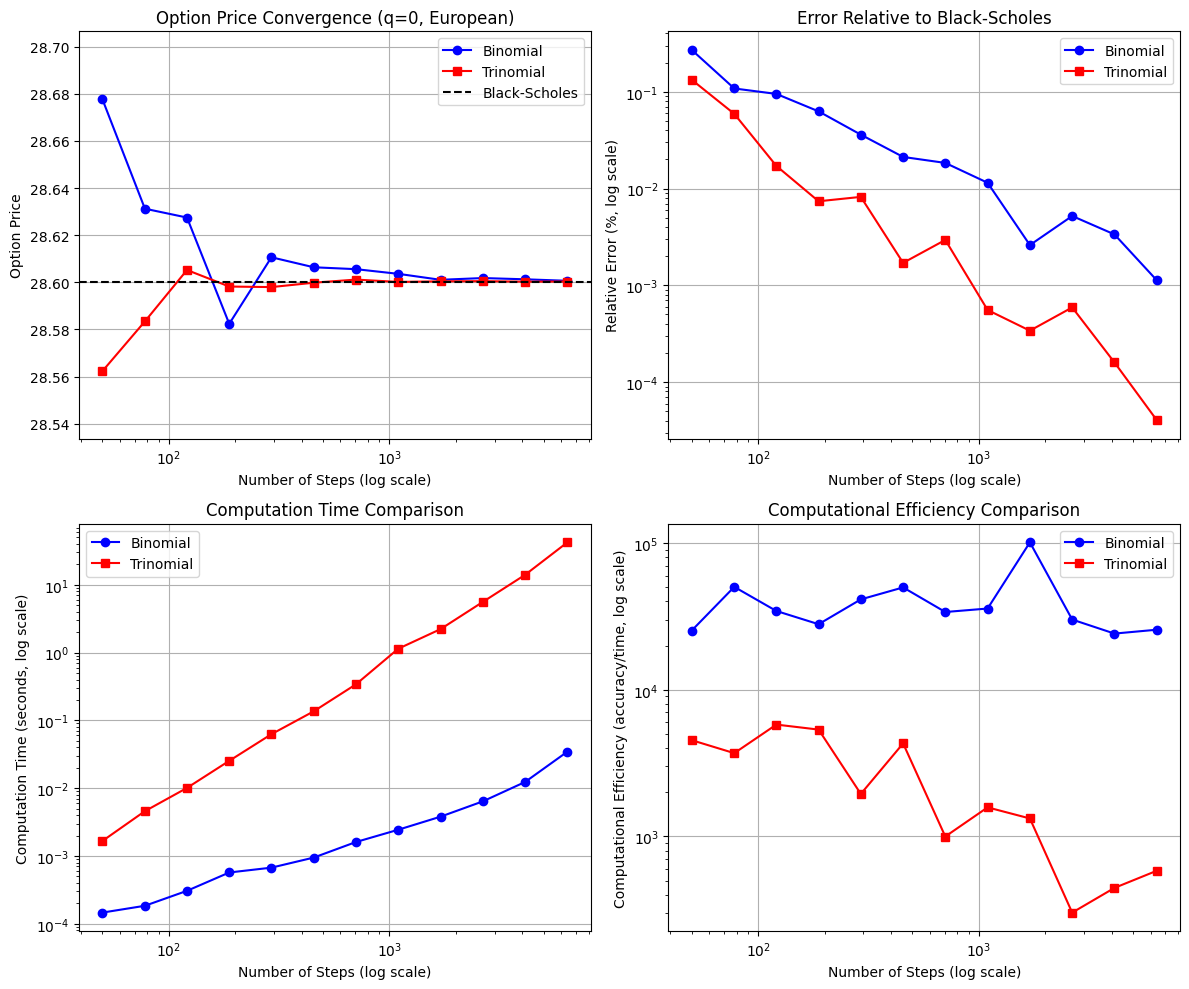


Convergence Order Comparison (q=0, European) =====
Binomial average local convergence order: 0.9657
Trinomial average local convergence order: 1.3422
Binomial global convergence order: 1.0417
Trinomial global convergence order: 1.4971


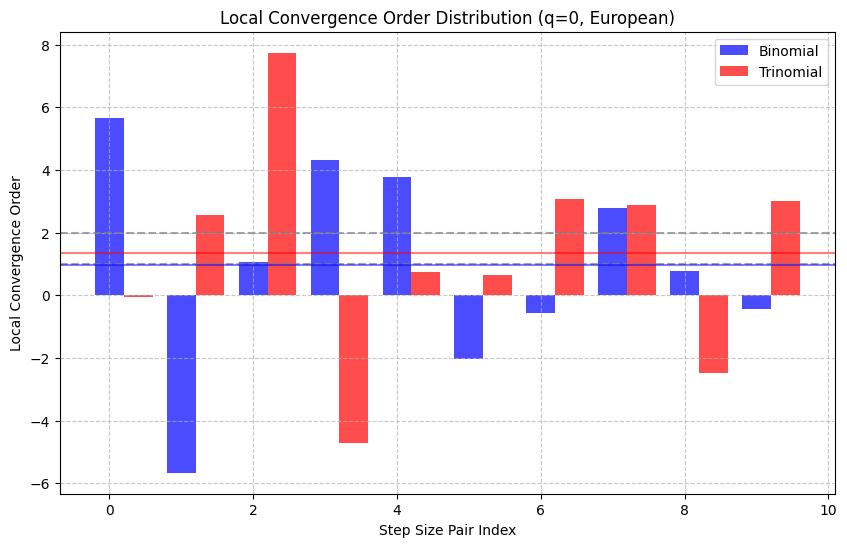

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm


def estimate_convergence_order_improved(pricing_func1, pricing_func2, S0, K, r, sigma, T, q, is_call, is_american,
                                       lambda_=1.22, threshold=1e-8, min_steps=50, max_steps=6400):

    steps_list = np.unique(np.round(np.logspace(
        np.log10(min_steps), np.log10(max_steps), 12)).astype(int))

    # Calculate BS analytical solution (if European option)
    if not is_american:
        bs_price = black_scholes_price(S0, K, r, sigma, T, q=q, is_call=is_call)
        print(f"Black-Scholes Price (q={q}): {bs_price:.8f}")

    # Calculate prices using both methods
    prices1 = []  # Binomial tree prices
    prices2 = []  # Trinomial tree prices
    times1 = []   # Binomial tree computation times
    times2 = []   # Trinomial tree computation times

    for steps in steps_list:
        # Binomial tree
        start_time = time.time()
        price1 = pricing_func1(S0, K, r, sigma, T, steps, q=q, is_call=is_call, is_american=is_american)
        times1.append(time.time() - start_time)
        prices1.append(price1)

        # Trinomial tree
        start_time = time.time()
        price2 = pricing_func2(S0, K, T, r, sigma, steps, q=q, lambda_=lambda_, is_call=is_call, is_american=is_american)
        times2.append(time.time() - start_time)
        prices2.append(price2)

    # Price data visualization - using unified Y-axis range
    plt.figure(figsize=(12, 10))

    # 1. Price convergence curve - unified coordinate system
    plt.subplot(2, 2, 1)
    plt.plot(steps_list, prices1, 'o-', color='blue', label='Binomial')
    plt.plot(steps_list, prices2, 's-', color='red', label='Trinomial')
    if not is_american:
        plt.axhline(y=bs_price, color='black', linestyle='--', label='Black-Scholes')

    # Set an appropriate Y-axis range to clearly display both methods
    all_prices = prices1 + prices2
    y_min = min(all_prices) - abs(min(all_prices) * 0.001)
    y_max = max(all_prices) + abs(max(all_prices) * 0.001)
    plt.ylim(y_min, y_max)

    plt.xscale('log')
    plt.xlabel('Number of Steps (log scale)')
    plt.ylabel('Option Price')
    plt.title(f'Option Price Convergence (q={q}, {"American" if is_american else "European"})')
    plt.legend()
    plt.grid(True)

    # 2. Relative error comparison (if European option)
    plt.subplot(2, 2, 2)
    if not is_american:
        # Error relative to BS analytical solution
        rel_errors1 = [abs((p - bs_price) / bs_price) * 100 for p in prices1]
        rel_errors2 = [abs((p - bs_price) / bs_price) * 100 for p in prices2]

        plt.plot(steps_list, rel_errors1, 'o-', color='blue', label='Binomial')
        plt.plot(steps_list, rel_errors2, 's-', color='red', label='Trinomial')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Number of Steps (log scale)')
        plt.ylabel('Relative Error (%, log scale)')
        plt.title('Error Relative to Black-Scholes')
        plt.legend()
        plt.grid(True)
    else:
        # Error relative to solution with maximum steps
        max_price1 = prices1[-1]
        max_price2 = prices2[-1]
        rel_errors1 = [abs((p - max_price1) / max_price1) * 100 for p in prices1]
        rel_errors2 = [abs((p - max_price2) / max_price2) * 100 for p in prices2]

        plt.plot(steps_list, rel_errors1, 'o-', color='blue', label='Binomial')
        plt.plot(steps_list, rel_errors2, 's-', color='red', label='Trinomial')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Number of Steps (log scale)')
        plt.ylabel('Relative Error (%, log scale)')
        plt.title('Error Relative to Maximum Steps Solution')
        plt.legend()
        plt.grid(True)

    # 3. Computation time comparison
    plt.subplot(2, 2, 3)
    plt.plot(steps_list, times1, 'o-', color='blue', label='Binomial')
    plt.plot(steps_list, times2, 's-', color='red', label='Trinomial')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Steps (log scale)')
    plt.ylabel('Computation Time (seconds, log scale)')
    plt.title('Computation Time Comparison')
    plt.legend()
    plt.grid(True)

    # 4. Computational efficiency comparison (accuracy/time)
    plt.subplot(2, 2, 4)
    if not is_american:
        # European option: accuracy defined as the inverse of the relative error to BS solution
        efficiency1 = [1/(err * t) for err, t in zip(rel_errors1, times1)]
        efficiency2 = [1/(err * t) for err, t in zip(rel_errors2, times2)]
    else:
        # American option: accuracy defined as the inverse of the relative error to max steps solution
        efficiency1 = [1/(err * t) for err, t in zip(rel_errors1, times1)]
        efficiency2 = [1/(err * t) for err, t in zip(rel_errors2, times2)]

    plt.plot(steps_list, efficiency1, 'o-', color='blue', label='Binomial')
    plt.plot(steps_list, efficiency2, 's-', color='red', label='Trinomial')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Steps (log scale)')
    plt.ylabel('Computational Efficiency (accuracy/time, log scale)')
    plt.title('Computational Efficiency Comparison')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate local convergence orders
    local_orders1 = []
    local_orders2 = []
    epsilon = 1e-12

    # Use all consecutive triplets of points to calculate local convergence order
    for i in range(len(steps_list) - 2):
        # Binomial tree
        V_N = prices1[i]
        V_2N = prices1[i+1]
        V_4N = prices1[i+2]
        N_ratio1 = steps_list[i+1] / steps_list[i]
        N_ratio2 = steps_list[i+2] / steps_list[i+1]
        diff1 = abs(V_2N - V_N)
        diff2 = abs(V_4N - V_2N)
        if diff1 > threshold and diff2 > threshold:
            p_local = np.log((diff1 + epsilon) / (diff2 + epsilon)) / np.log(N_ratio1)
            local_orders1.append(p_local)

        # Trinomial tree
        V_N = prices2[i]
        V_2N = prices2[i+1]
        V_4N = prices2[i+2]
        diff1 = abs(V_2N - V_N)
        diff2 = abs(V_4N - V_2N)
        if diff1 > threshold and diff2 > threshold:
            p_local = np.log((diff1 + epsilon) / (diff2 + epsilon)) / np.log(N_ratio2)
            local_orders2.append(p_local)

    avg_local1 = np.mean(local_orders1) if local_orders1 else None
    avg_local2 = np.mean(local_orders2) if local_orders2 else None

    # Global convergence order estimation - logarithmic regression
    if not is_american:
        # European option: error relative to BS analytical solution
        errors1 = [abs(p - bs_price) for p in prices1]
        errors2 = [abs(p - bs_price) for p in prices2]
    else:
        # American option: error relative to max steps solution
        errors1 = [abs(p - prices1[-1]) for p in prices1]
        errors2 = [abs(p - prices2[-1]) for p in prices2]

    # Remove zero errors to avoid log(0)
    valid_indices1 = [i for i, err in enumerate(errors1) if err > 1e-10]
    valid_indices2 = [i for i, err in enumerate(errors2) if err > 1e-10]

    if valid_indices1:
        log_steps1 = np.log(np.array([steps_list[i] for i in valid_indices1]))
        log_errors1 = np.log(np.array([errors1[i] for i in valid_indices1]))
        coeffs1 = np.polyfit(log_steps1, log_errors1, 1)
        global_order1 = -coeffs1[0]
    else:
        global_order1 = None

    if valid_indices2:
        log_steps2 = np.log(np.array([steps_list[i] for i in valid_indices2]))
        log_errors2 = np.log(np.array([errors2[i] for i in valid_indices2]))
        coeffs2 = np.polyfit(log_steps2, log_errors2, 1)
        global_order2 = -coeffs2[0]
    else:
        global_order2 = None

    # Print results
    print(f"\nConvergence Order Comparison (q={q}, {'American' if is_american else 'European'}) =====")
    print(f"Binomial average local convergence order: {avg_local1:.4f}" if avg_local1 is not None else "Binomial local convergence order: Unable to calculate")
    print(f"Trinomial average local convergence order: {avg_local2:.4f}" if avg_local2 is not None else "Trinomial local convergence order: Unable to calculate")
    print(f"Binomial global convergence order: {global_order1:.4f}" if global_order1 is not None else "Binomial global convergence order: Unable to calculate")
    print(f"Trinomial global convergence order: {global_order2:.4f}" if global_order2 is not None else "Trinomial global convergence order: Unable to calculate")

    # Plot distribution of local convergence orders
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(local_orders1)) if local_orders1 else []
    plt.bar(x_positions, local_orders1, width=0.4, label='Binomial', color='blue', alpha=0.7)

    x_positions = np.arange(len(local_orders2)) if local_orders2 else []
    plt.bar(x_positions + 0.4, local_orders2, width=0.4, label='Trinomial', color='red', alpha=0.7)

    plt.axhline(y=1.0, linestyle='--', color='gray', alpha=0.7)
    plt.axhline(y=2.0, linestyle='--', color='gray', alpha=0.7)

    if avg_local1 is not None:
        plt.axhline(y=avg_local1, linestyle='-', color='blue', alpha=0.5)
    if avg_local2 is not None:
        plt.axhline(y=avg_local2, linestyle='-', color='red', alpha=0.5)

    plt.xlabel('Step Size Pair Index')
    plt.ylabel('Local Convergence Order')
    plt.title(f'Local Convergence Order Distribution (q={q}, {"American" if is_american else "European"})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return {
        'steps': steps_list,
        'prices1': prices1,
        'prices2': prices2,
        'times1': times1,
        'times2': times2,
        'local_orders1': local_orders1,
        'local_orders2': local_orders2,
        'avg_local1': avg_local1,
        'avg_local2': avg_local2,
        'global_order1': global_order1,
        'global_order2': global_order2
    }


S0 = 90
K = 100
r = 0.05
sigma = 0.3
T = 5
q_no_div = 0
is_call = True
is_american = False

results = estimate_convergence_order_improved(
    binomial_price, trinomial_tree_fixed,
    S0, K, r, sigma, T, q_no_div, is_call, is_american
)
